In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

In [2]:
# Define paths
dataset_dir = "D://SEM-4//PROJECTS//ML//DATASET//Archive"  # replace with the path to your dataset directory

In [3]:
# Image data generators with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.25,  # 25% for validation/testing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Training generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 8738 images belonging to 13 classes.


In [5]:
# Validation generator
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2909 images belonging to 13 classes.


In [6]:
# Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze the layers of MobileNet model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Feature extraction
x = Flatten()(base_model.output)

In [9]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(Flatten())
    
    # Tune the number of units in the Dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(13, activation='softmax'))  # 13 classes

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory='mobilenet_tuner_dir',
    project_name='mobilenet_image_classification'
)

Reloading Tuner from mobilenet_tuner_dir\mobilenet_image_classification\tuner0.json


In [11]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# Search for the best hyperparameters
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # max epochs
    callbacks=[early_stopping]
)

In [13]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

In [15]:
# Train the model with the optimal hyperparameters
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # you can adjust the number of epochs
    callbacks=[early_stopping]
)

Epoch 1/50


C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1313 - loss: 2.6341

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 852s 12s/step - accuracy: 0.1320 - loss: 2.6312 - val_accuracy: 0.2425 - val_loss: 2.2181
Epoch 2/50
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.2969 - loss: 2.1637

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.2969 - loss: 2.1637 - val_accuracy: 0.2796 - val_loss: 2.1318
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 728s 10s/step - accuracy: 0.2875 - loss: 2.0963 - val_accuracy: 0.2688 - val_loss: 2.0947
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3125 - loss: 2.0387 - val_accuracy: 0.2581 - val_loss: 2.0762
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 692s 10s/step - accuracy: 0.3828 - loss: 1.8423 - val_accuracy: 0.3143 - val_loss: 2.0629
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4688 - loss: 1.6041 - val_accuracy: 0.2366 - val_loss: 2.1603
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 626s 9s/step - accuracy: 0.4266 - loss: 1.6936 - val_accuracy: 0.3345 - val_loss: 2.0325
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3984 - loss: 1.8168 - val_accuracy: 0.3333 - val_loss: 2.0036
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 619s 9s/step - accuracy: 0.4671 - loss: 1.5916 - val_accuracy: 0.3487 - val_loss: 

In [16]:
# Print training and validation accuracy for each epoch
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    print(f'Epoch {epoch + 1}: Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%')

Epoch 1: Training Accuracy: 18.05%, Validation Accuracy: 24.25%
Epoch 2: Training Accuracy: 29.69%, Validation Accuracy: 27.96%
Epoch 3: Training Accuracy: 31.53%, Validation Accuracy: 26.88%
Epoch 4: Training Accuracy: 31.25%, Validation Accuracy: 25.81%
Epoch 5: Training Accuracy: 39.65%, Validation Accuracy: 31.43%
Epoch 6: Training Accuracy: 46.88%, Validation Accuracy: 23.66%
Epoch 7: Training Accuracy: 43.37%, Validation Accuracy: 33.45%
Epoch 8: Training Accuracy: 39.84%, Validation Accuracy: 33.33%
Epoch 9: Training Accuracy: 46.92%, Validation Accuracy: 34.87%
Epoch 10: Training Accuracy: 60.94%, Validation Accuracy: 37.63%
Epoch 11: Training Accuracy: 50.13%, Validation Accuracy: 34.73%
Epoch 12: Training Accuracy: 50.00%, Validation Accuracy: 26.88%
Epoch 13: Training Accuracy: 51.64%, Validation Accuracy: 33.91%
Epoch 14: Training Accuracy: 51.56%, Validation Accuracy: 35.48%
Epoch 15: Training Accuracy: 54.33%, Validation Accuracy: 34.13%


In [17]:
# Get the final training accuracy
final_training_accuracy = history.history['accuracy'][-1]
print(f'Final Training Accuracy: {final_training_accuracy * 100:.2f}%')

Final Training Accuracy: 54.33%


In [18]:
# You can also get the final validation accuracy
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%')

Final Validation Accuracy: 34.13%


In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

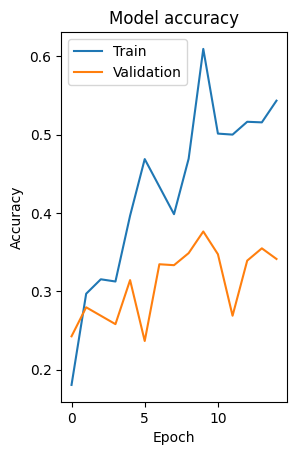

In [20]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

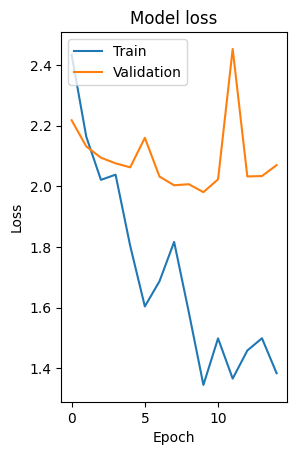

In [21]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [22]:
plt.show()

In [23]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2909 images belonging to 13 classes.


In [24]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 532ms/step - accuracy: 0.3859 - loss: 1.9036
Test Accuracy: 34.58%
Test Loss: 1.9958
